In [2]:
import os
import keras
import tensorflow as tf
import numpy as np
import string, re
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
batch_size = 32
raw_train_ds = keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size, validation_split=0.2, subset="training", seed=1337)
raw_val_ds  =  keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size, validation_split=0.2, subset="validation", seed=1337)
raw_test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=batch_size)
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(1):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Deca

In [4]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

max_features = 20000
embedding_dim = 128
sequence_length = 500
vectorize_layer = keras.layers.TextVectorization(standardize=custom_standardization, max_tokens=max_features, output_sequence_length=sequence_length)
vectorize_layer.adapt(raw_train_ds.map(lambda x,y:x))

def vecrorize_text(text, label):
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vecrorize_text).cache().prefetch(buffer_size=10)
val_ds = raw_val_ds.map(vecrorize_text).cache().prefetch(buffer_size=10)
test_ds = raw_test_ds.map(vecrorize_text).cache().prefetch(buffer_size=10)
for texts,labels in train_ds.take(1):
    print(texts)
    print(labels)

tf.Tensor(
[[  10    7  240 ...    0    0    0]
 [  10   17   13 ...    0    0    0]
 [  89   76   69 ...    0    0    0]
 ...
 [1196   50   11 ...    0    0    0]
 [  47   13  136 ...    0    0    0]
 [  11  727  159 ...    0    0    0]], shape=(32, 500), dtype=int64)
tf.Tensor([1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0], shape=(32,), dtype=int32)


我们从每一步的输入和输出形状（shape）来分析代码。

```python
inputs = keras.Input(shape=(None,), dtype="int64")
```

- 这行代码定义了一个输入层，输入的 `shape` 是 `(None,)`，表示输入序列的长度可以是任意的。`dtype="int64"` 表示输入数据的类型是整数。这一层的输出 `shape` 是 `(batch_size, sequence_length)`，其中 `sequence_length` 是输入的实际序列长度。

```python
x = keras.layers.Embedding(max_features, embedding_dim)(inputs)
```

- 这一层是嵌入层（Embedding layer），它将输入的整数序列转换为密集的向量表示。`max_features` 表示词汇表的大小，`embedding_dim` 表示每个词嵌入向量的维度。输出 `shape` 是 `(batch_size, sequence_length, embedding_dim)`，其中 `embedding_dim` 是嵌入向量的维度。

```python
x = keras.layers.Dropout(0.5)(x)
```

- Dropout 层用于在训练期间随机丢弃一部分神经元来防止过拟合。Dropout 层不会改变 `shape`，因此输出 `shape` 仍然是 `(batch_size, sequence_length, embedding_dim)`。

```python
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
```

- 这是一维卷积层（Conv1D layer）。`128` 表示卷积核的数量，也就是输出通道数。`7` 表示卷积核的大小（filter size）。`strides=3` 表示卷积核的步幅为3。`padding="valid"` 表示不进行填充。输出的 `shape` 将是 `(batch_size, new_sequence_length, 128)`，其中 `new_sequence_length` 由以下公式计算：

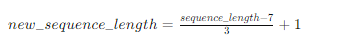

总结一下各个步骤的 `shape` 变化：

1. `inputs`：`(batch_size, sequence_length)`
2. `Embedding`：`(batch_size, sequence_length, embedding_dim)`
3. `Dropout`：`(batch_size, sequence_length, embedding_dim)`
4. `Conv1D`：`(batch_size, new_sequence_length, 128)`

In [5]:
inputs = keras.Input(shape=(None,), dtype="int64")
x = keras.layers.Embedding(max_features, embedding_dim)(inputs)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x) # (B, 165, 128)
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x) # (B, 53, 128)
x = keras.layers.GlobalMaxPooling1D()(x)  # (B, 128)  沿着时间步维度（即第二个维度，长度为 53）进行最大池化操作。
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="sigmoid", name="predictions")(x)
model = keras.Model(inputs, predictions)
model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(),
             metrics=[keras.metrics.BinaryAccuracy()])

In [41]:
model.fit(train_ds, validation_data=val_ds, epochs=3) # 4.2G-4.4G

Epoch 1/3
625/625 [==============================] - 2s 3ms/step - loss: 0.5130 - binary_accuracy: 0.7035 - val_loss: 0.3061 - val_binary_accuracy: 0.8704
Epoch 2/3
625/625 [==============================] - 2s 3ms/step - loss: 0.2247 - binary_accuracy: 0.9122 - val_loss: 0.3440 - val_binary_accuracy: 0.8604
Epoch 3/3
625/625 [==============================] - 2s 3ms/step - loss: 0.1161 - binary_accuracy: 0.9577 - val_loss: 0.4223 - val_binary_accuracy: 0.8712


In [42]:
model.evaluate(test_ds)

782/782 [==============================] - 6s 8ms/step - loss: 0.4301 - binary_accuracy: 0.8631


[0.43008673191070557, 0.8630800247192383]

# 直接以字符串为输入

In [43]:
inputs = keras.Input(shape=(1,), dtype="string")
indices = vectorize_layer(inputs)
outputs = model(indices)
end_to_end_model = keras.Model(inputs, outputs)
end_to_end_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
end_to_end_model.evaluate(raw_test_ds)

782/782 [==============================] - 5s 6ms/step - loss: 0.4301 - accuracy: 0.8631


[0.43008673191070557, 0.8630800247192383]